> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

<h4><div style="text-align: right"> Due date: April 1, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab04.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2018142192] [최순규]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-03-28 12:44:20.256238


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [121]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [4]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [55]:
print('STEP 1: DEFINE DATASET')
# RandomAffine: Random Rotation + Random Translation + Random Scale
# The original size of the MNIST image is 28x28
# The given mean and std of the MNIST is 0.1307 and 0.3081
# First padding 28->40(pad 6) Second padding 40->80(pad 20)
train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        transform = transforms.Compose([
                            transforms.Pad(6),
                            transforms.RandomAffine((-45,45), translate=(0.2, 0.2), scale=(0.7,1.2)),
                            transforms.Pad(20),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307, ), (0.3081, ))
                        ]),
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        transform = transforms.Compose([
                            transforms.Pad(6),
                            transforms.RandomAffine((-45,45), translate=(0.2, 0.2), scale=(0.7,1.2)),
                            transforms.Pad(20),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307, ), (0.3081, ))
                        ]),
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [56]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


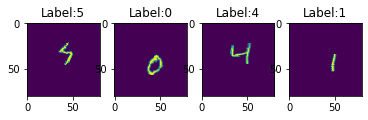

In [57]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [58]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [59]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):
    def __init__(self):
        super(STN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=9)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
        self.avg2 = nn.AvgPool2d(2, stride=2)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(20, 20, kernel_size=5),
            #nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(23120, 20),
            nn.ReLU(True),
            nn.Linear(20, 6)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        #print(xs.size())
        xs = xs.view(-1, 23120)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        x = self.avg2(x)
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = STN_CNN()

STEP 3: CREATE MODEL CLASS (STN_CNN)


In [60]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
conv1.weight 	 torch.Size([32, 1, 9, 9])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 7, 7])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 1600])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [61]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [62]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############
# I will use F.nll loss for Loss Class, and use code below
# Softmax + CrossEntropyLoss = Log_Softmax + Nll_loss
# I first attempt model training with log_softmax+nll_loss, and it worked well. So I didn't fix it to CrossEntropy


# Model to GPU

model.to(device0)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        #print(img.size())
        img, label = img.to(device0), label.to(device0)
        optimizer.zero_grad()
        output = model(img)
        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        #############
        # CODE HERE #
        #############
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model.eval()
    correct = 0
    total = 0
    for img, label in test_loader:
        img, label = img.to(device0), label.to(device0)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted==label).sum()
        
    accuracy = 100*correct.item()/total
    print(f'Test set accuracy: {correct.item()}/{total} ({accuracy: .2f}%)')
    #############
    # CODE HERE #
    #############
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.306802  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.485392  
Test set accuracy: 9030/9984 ( 90.44%)
////Epoch elapsed time: 10.338676452636719////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.474349  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.327418  
Test set accuracy: 9432/9984 ( 94.47%)
////Epoch elapsed time: 10.606171131134033////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.388740  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.202103  
Test set accuracy: 9538/9984 ( 95.53%)
////Epoch elapsed time: 9.992096424102783////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.281278  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.290233  
Test set accuracy: 9632/9984 ( 96.47%)
////Epoch elapsed time: 10.416854858398438////

Train Epoch: 4 [0/60000 (0%) / Lea

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [63]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [64]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  99.10857371794872


In [67]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [111]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        #############
        # CODE HERE #
        #############
        x = self.model.stn(x)
        return x
    
    def visualize(self, img):
        stn_img = self.forward_stn(img)
        
        with torch.no_grad():
            in_grid = reprocess_image(
                v_utils.make_grid(img, nrow = 4))

            out_grid = reprocess_image(
                v_utils.make_grid(stn_img, nrow = 4))

            # Plot the results side-by-side
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(in_grid)
            axarr[0].set_title('Dataset Images')

            axarr[1].imshow(out_grid)
            axarr[1].set_title('Transformed Images')

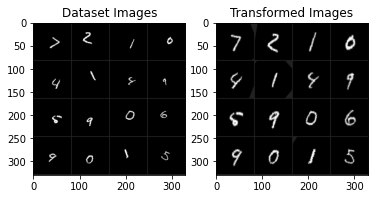

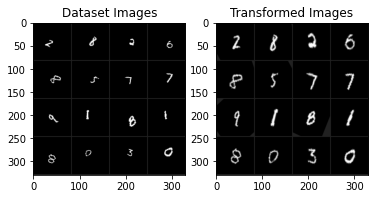

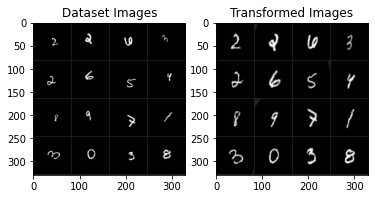

In [112]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [122]:
#############
# CODE HERE #
#############
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=9)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
        self.avg2 = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.avg2(x)
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [123]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
conv1.weight 	 torch.Size([32, 1, 9, 9])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 7, 7])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 1600])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])


In [124]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [125]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############
#I use F.nll loss for Loss Class, and use code below


# Model to GPU

model_nostn.to(device0)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        #print(img.size())
        img, label = img.to(device0), label.to(device0)
        optimizer.zero_grad()
        output = model_nostn(img)
        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        #############
        # CODE HERE #
        #############
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model_nostn.eval()
    correct = 0
    total = 0
    for img, label in test_loader:
        img, label = img.to(device0), label.to(device0)
        output = model_nostn(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted==label).sum()
        
    accuracy = 100*correct.item()/total
    print(f'Test set accuracy: {correct.item()}/{total} ({accuracy: .2f}%)')
    #############
    # CODE HERE #
    #############
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.307385  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.210067  
Test set accuracy: 7257/9984 ( 72.69%)
////Epoch elapsed time: 10.217346668243408////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:1.004884  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.820901  
Test set accuracy: 8529/9984 ( 85.43%)
////Epoch elapsed time: 10.288692235946655////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.684963  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.619406  
Test set accuracy: 8965/9984 ( 89.79%)
////Epoch elapsed time: 10.34029769897461////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.589007  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.434266  
Test set accuracy: 9054/9984 ( 90.69%)
////Epoch elapsed time: 10.228468418121338////

Train Epoch: 4 [0/60000 (0%) / Lea

#### Best accuracy of the model without ST module


In [126]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  97.49599358974359


## Discussion

이번 실험에서는 spatial transformer network을 구현하였다. Spatial transformer network는 하나의 CNN 네트워크 안에 삽입되어 모델이 spatial invariant한 특성을 가질 수 있도록 도와주는 계층이다.
Spatial transformer network가 포함된 layer는 따라서 공간에서 변형된 이미지에 대한 classification도 더 잘 수행할 수 있다.

두 모델의 성능 비교를 위해 우리는 기존의 MNIST 데이터셋을 받아오고, 여기에 rotate, translate, scailing을 적용해 Distorted MNIST를 제작하였다.

이후 spatial transformer network가 적용된 STN_CNN 모델과 별도의 spatial transformer network가 적용되지 않은 CNN모델을 구현하여 두 모델의 성능을 비교해보았다.
전자의 경우 최대 99.11%까지 test accuracy가 증가하는 모습을 보였으며 후자의 경우 97.50%까지 증가하였다.

이를 통해 spatial transformer network가 distorted MNIST와 같은 데이터를 classification하는 것에 도움을 주고, 일반 모델에 비해 spatial invariant한 특성을 더 가진다는 것을 확인할 수 있었다.

MNIST dataset의 경우 전처리가 매우 훌륭하게 적용된 이미지 데이터이기 때문에 spatial transformer network가 없는 일반 모델에서도 어느정도는 높은 정확도가 나온다.
MNIST보다 비교적 전처리가 덜 되었거나, 학습이 어려운 데이터셋, 다양한 각도에서 찍힌 사진들이 포함된 데이터셋의 경우 이런 spatial invariat한 feature이 더 중요할 것으로 보인다.

### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>